# Introduction

In this notebook, we develop a machine learning model to predict the 2022 FIFA games leading up to the 2022 FIFA World Cup. This test dataset contained 247 games, and the outcomes were predicted based on a training data from the past 2 decades of international football (5641 matches). Ultimately, we were able to achieve a model accuracy score of >55%. 

# Data Import

Importing all the necessary libraries.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from matplotlib.legend_handler import HandlerLine2D

Importing the match_history.csv and test_set.csv files, assuming they are in the same directory as the code.

In [ ]:
dataset = r"./match_history.csv"
testset = r"./test_set.csv"
training_matches = pd.read_csv(dataset)
testing_matches = pd.read_csv(testset)

# Data Transformation & Exploration

In [ ]:
# Remove friendly games because the results are not as relevant as the others
training_matches = training_matches[training_matches["tournament"] != 'Friendly']

# Using matches before 2012 to calculate missing values, when needed
training_matches_before_2012 = training_matches[training_matches["date"] < '2012-01-01']
training_matches_before_2012 = training_matches_before_2012.reset_index()

# Remove data before 2012
# training_matches = training_matches[training_matches["date"] >= '2012-01-01']
training_matches = training_matches.reset_index()
training_matches

,index,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,1,2004-09-04,Albania,Greece,Europe,Europe,94,14,0,0,...,No,Win,NaN,90.0,NaN,59.0,74.5,82.8,83.7,85.2
1,2,2004-09-04,Austria,England,Europe,Europe,90,7,0,0,...,No,Draw,83.0,88.0,76.2,73.0,74.0,90.5,88.7,91.2
2,3,2004-09-04,Croatia,Hungary,Europe,Europe,25,76,0,0,...,No,Win,77.0,74.0,80.5,78.7,79.0,71.8,75.7,70.2
3,4,2004-09-04,Denmark,Ukraine,Europe,Europe,15,87,0,0,...,No,Draw,82.0,NaN,79.5,85.0,81.5,NaN,81.7,65.8
4,5,2004-09-04,Iceland,Bulgaria,Europe,Europe,80,41,0,0,...,No,Lose,78.0,78.0,68.8,77.0,69.2,70.5,79.7,78.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3409,5634,2021-12-06,Tunisia,United Arab Emirates,Africa,Asia,29,70,1512,1350,...,No,Win,NaN,70.0,70.8,72.3,74.0,63.0,64.3,67.0
3410,5635,2021-12-07,Morocco,Saudi Arabia,Africa,Asia,28,48,1525,1441,...,No,Win,82.0,70.0,81.2,81.7,76.2,72.8,67.7,72.8
3411,5636,2021-12-07,Algeria,Egypt,Africa,Africa,32,45,1508,1449,...,No,Draw,78.0,NaN,78.0,81.0,78.0,NaN,79.3,70.8
3412,5638,2021-12-11,Morocco,Algeria,Africa,Africa,28,32,1525,1508,...,Yes,Lose,82.0,78.0,81.2,81.7,76.2,78.0,81.0,78.0


In [ ]:
# See datatypes for different features, we need features we want to use to be numeric datatypes (not 'objects')
training_matches.dtypes

index                              int64
date                              object
home_team                         object
away_team                         object
home_team_continent               object
away_team_continent               object
home_team_fifa_rank                int64
away_team_fifa_rank                int64
home_team_total_fifa_points        int64
away_team_total_fifa_points        int64
home_team_score                    int64
away_team_score                    int64
tournament                        object
city                              object
country                           object
neutral_location                    bool
shoot_out                         object
home_team_result                  object
home_team_goalkeeper_score       float64
away_team_goalkeeper_score       float64
home_team_mean_defense_score     float64
home_team_mean_offense_score     float64
home_team_mean_midfield_score    float64
away_team_mean_defense_score     float64
away_team_mean_o

## Code for replacing the NaN values in the data set

In [ ]:
# print how many NaN results there are for each feature 
# the only relevant NaN values are for the offense/defense/midfield scores
# There are also NaN values for the Total Fifa Points, however we did not
# use this feature

print("Home team's goalkeeper score missing for", training_matches['home_team_goalkeeper_score'].isnull().sum(), "matches!")
print("Home team's defense score missing for", training_matches['home_team_mean_defense_score'].isnull().sum(), "matches!")
print("Home team's midfield score missing for", training_matches['home_team_mean_midfield_score'].isnull().sum(), "matches!")
print("Home team's offense score missing for", training_matches['home_team_mean_offense_score'].isnull().sum(), "matches!")
print("Away team's goalkeeper score missing for", training_matches['away_team_goalkeeper_score'].isnull().sum(), "matches!")
print("Away team's defense score missing for", training_matches['away_team_mean_defense_score'].isnull().sum(), "matches!")
print("Away team's midfield score missing for", training_matches['away_team_mean_midfield_score'].isnull().sum(), "matches!")
print("Away team's offense score missing for", training_matches['away_team_mean_offense_score'].isnull().sum(), "matches!")

Home team's goalkeeper score missing for 223 matches!
Home team's defense score missing for 229 matches!
Home team's midfield score missing for 149 matches!
Home team's offense score missing for 95 matches!
Away team's goalkeeper score missing for 245 matches!
Away team's defense score missing for 239 matches!
Away team's midfield score missing for 166 matches!
Away team's offense score missing for 106 matches!


In [ ]:
# print the % of NaN results there are in for each feature

lgth = len(training_matches)

print("Home team's goalkeeper score missing for", (training_matches['home_team_goalkeeper_score'].isnull().sum()/lgth)*100, "% of the matches!")
print("Home team's defense score missing for", (training_matches['home_team_mean_defense_score'].isnull().sum()/lgth)*100, "% of the matches!")
print("Home team's midfield score missing for", (training_matches['home_team_mean_midfield_score'].isnull().sum()/lgth)*100, "% of the matches!")
print("Home team's offense score missing for", (training_matches['home_team_mean_offense_score'].isnull().sum()/lgth)*100, "% of the matches!")
print("Away team's goalkeeper score missing for", (training_matches['away_team_goalkeeper_score'].isnull().sum()/lgth)*100, "% of the matches!")
print("Away team's defense score missing for", (training_matches['away_team_mean_defense_score'].isnull().sum()/lgth)*100, "% of the matches!")
print("Away team's midfield score missing for", (training_matches['away_team_mean_midfield_score'].isnull().sum()/lgth)*100, "% of the matches!")
print("Away team's offense score missing for", (training_matches['away_team_mean_offense_score'].isnull().sum()/lgth)*100, "% of the matches!")

Home team's goalkeeper score missing for 6.531927357937903 % of the matches!
Home team's defense score missing for 6.7076742823667255 % of the matches!
Home team's midfield score missing for 4.364381956649091 % of the matches!
Home team's offense score missing for 2.7826596367896896 % of the matches!
Away team's goalkeeper score missing for 7.176332747510251 % of the matches!
Away team's defense score missing for 7.000585823081429 % of the matches!
Away team's midfield score missing for 4.862331575864089 % of the matches!
Away team's offense score missing for 3.1048623315758643 % of the matches!


### First approach:

In [ ]:
# #Creates functions which replace NaN values with the mean values from the relevant team
# #If the NaN is e.g. home offense score, then it will find the mean offense score from that
# #team's home matches. If this is not possible, it will use the mean from that teams away matches.
# #If neither of these are possible, it will use the mean score from all teams in the relevant feature

# def fill_home_rank(dataframe, column):
    
#     count = len(dataframe.index)
#     for i in range(count):
#         if pd.isna(dataframe.loc[i, column]):
#             team = dataframe.loc[i, "home_team"]
#             team_table = dataframe[dataframe["home_team"] == team]
#             val = team_table[column].mean()
#             dataframe.loc[i, column] = val
#         if pd.isna(dataframe.loc[i, column]):
#             team = dataframe.loc[i, "home_team"]
#             team_table = dataframe[dataframe["away_team"] == team]
#             # val = team_table[column].mean()
#             val = team_table["away" + column[4:]].mean()
#             dataframe.loc[i, column] = val
#         if pd.isna(dataframe.loc[i, column]):
#             dataframe.loc[i, column] = dataframe[column].mean()
            
            
# def fill_away_rank(dataframe, column):
    
#     count = len(dataframe.index)
#     for i in range(count):
#         if pd.isna(dataframe.loc[i, column]):
#             team = dataframe.loc[i, "away_team"]
#             team_table = dataframe[dataframe["away_team"] == team]
#             val = team_table[column].mean()
#             dataframe.loc[i, column] = val
#         if pd.isna(dataframe.loc[i, column]):
#             team = dataframe.loc[i, "away_team"]
#             team_table = dataframe[dataframe["home_team"] == team]
#             # val = team_table[column].mean()
#             val = team_table["home" + column[4:]].mean()
#             dataframe.loc[i, column] = val
#         if pd.isna(dataframe.loc[i, column]):
#             dataframe.loc[i, column] = dataframe[column].mean()
        
# fill_home_rank(training_matches, "home_team_goalkeeper_score")
# fill_home_rank(training_matches, "home_team_mean_defense_score")
# fill_home_rank(training_matches, "home_team_mean_offense_score")
# fill_home_rank(training_matches, "home_team_mean_midfield_score")

# fill_away_rank(training_matches, "away_team_goalkeeper_score")
# fill_away_rank(training_matches, "away_team_mean_defense_score")
# fill_away_rank(training_matches, "away_team_mean_offense_score")
# fill_away_rank(training_matches, "away_team_mean_midfield_score")

We made the observation that goalkeeper/defense/midfield/offense scores are not changing after each match for a given team, so we tried another approach of completing the missing scores. <br>
For example, the following code gives the goalkeeper score for Chile. The score remains the same for many matches until it changes.

In [ ]:
count = len(training_matches.index)
for i in range(count):
  if training_matches.loc[i, "home_team"] == 'Chile':
    print(training_matches.loc[i, "home_team_goalkeeper_score"], end=" Home\n")
  if training_matches.loc[i, "away_team"] == 'Chile':
    print(training_matches.loc[i, "away_team_goalkeeper_score"], end=" Away\n")

81.0 Home
81.0 Home
81.0 Home
81.0 Away
nan Away
nan Away
69.0 Home
69.0 Away
69.0 Away
69.0 Away
69.0 Away
69.0 Home
69.0 Away
69.0 Home
69.0 Away
69.0 Home
69.0 Away
70.0 Home
70.0 Home
70.0 Away
70.0 Home
70.0 Away
70.0 Home
70.0 Away
70.0 Away
70.0 Away
75.0 Home
75.0 Away
75.0 Away
75.0 Home
75.0 Away
75.0 Home
75.0 Home
75.0 Away
79.0 Home
79.0 Away
79.0 Home
79.0 Home
78.0 Away
78.0 Home
78.0 Away
78.0 Home
78.0 Home
78.0 Away
78.0 Away
80.0 Home
80.0 Away
80.0 Home
80.0 Away
80.0 Home
80.0 Away
80.0 Home
81.0 Home
81.0 Away
81.0 Home
81.0 Home
81.0 Away
81.0 Away
81.0 Away
83.0 Home
83.0 Home
83.0 Home
83.0 Home
83.0 Home
83.0 Home
83.0 Home
83.0 Away
83.0 Home
83.0 Away
83.0 Home
83.0 Away
83.0 Away
83.0 Home
83.0 Away
83.0 Away
83.0 Away
85.0 Away
85.0 Home
85.0 Away
85.0 Home
85.0 Away
85.0 Home
85.0 Away
85.0 Home
85.0 Away
85.0 Away
85.0 Home
85.0 Away
85.0 Home
85.0 Home
82.0 Away
82.0 Home
82.0 Away
79.0 Away
79.0 Away
79.0 Home
79.0 Away
79.0 Home
79.0 Away
77.0 Away
77

### Second approach:

In [ ]:
# For each missing score, we search for the closest date the team played a match 
# (before or after the one with a missing value), and use the score from that one
# If that score is missing in all matches played by the team, we get the score 
# from a team with similar fifa rank


# find the most recent match before the one with the missing score
# if needed, check the dataframe_extra, with older matches
def search_score_before(team, dataframe, dataframe_extra, column, index):
    j = index - 1
    while j >= 0 and (dataframe.loc[j, "home_team"] != team or pd.isna(dataframe.loc[j, "home" + column[4:]])) and \
          (dataframe.loc[j, "away_team"] != team or pd.isna(dataframe.loc[j, "away" + column[4:]])):
        j -= 1
    if j >= 0: # If there exists a recent match where the team played
        if dataframe.loc[j, "home_team"] == team:
            val = dataframe.loc[j, "home" + column[4:]]
        else:
            val = dataframe.loc[j, "away" + column[4:]]
        date = dataframe.loc[j, "date"]
    else: # search the most recent game in the extra dataframe (with older matches)
        j = len(dataframe_extra.index) - 1
        while j >= 0 and (dataframe_extra.loc[j, "home_team"] != team or pd.isna(dataframe_extra.loc[j, "home" + column[4:]])) and \
              (dataframe_extra.loc[j, "away_team"] != team or pd.isna(dataframe_extra.loc[j, "away" + column[4:]])):
            j -= 1
        if j >= 0:
            if dataframe_extra.loc[j, "home_team"] == team:
                val = dataframe_extra.loc[j, "home" + column[4:]]
            else:
                val = dataframe_extra.loc[j, "away" + column[4:]]
            date = dataframe_extra.loc[j, "date"]
        else: # return None is there is no match with the required score
            val = None
            date = None
    return val, date


# find the closest match after the one with the missing score
def search_score_after(team, dataframe, column, i, count):
    j = i + 1
    while j < count and (dataframe.loc[j, "home_team"] != team or pd.isna(dataframe.loc[j, "home" + column[4:]])) and \
          (dataframe.loc[j, "away_team"] != team or pd.isna(dataframe.loc[j, "away" + column[4:]])):
        j += 1
    if j < count: # if there exists a match where the team played after the current one
        if dataframe.loc[j, "home_team"] == team:
            val = dataframe.loc[j, "home" + column[4:]]
        else:
            val = dataframe.loc[j, "away" + column[4:]]
        date = dataframe.loc[j, "date"]
    else: # return None is there is no match with the required score
        val = None
        date = None
    return val, date


# searching for a team with similar rank
def get_similar_score(team_rank, dataframe, column):
    count = len(dataframe.index)
    threshold = 3 # difference in rank to be equal or less than 3
    for i in range(count):
        if abs(dataframe.loc[i, "home_team_fifa_rank"] - team_rank) <= 3 and not pd.isna(dataframe.loc[i, "home" + column[4:]]):
            return dataframe.loc[i, "home" + column[4:]]
        if abs(dataframe.loc[i, "away_team_fifa_rank"] - team_rank) <= 3 and not pd.isna(dataframe.loc[i, "away" + column[4:]]):
            return dataframe.loc[i, "home" + column[4:]]


# fill the missing values for a given column
def fill_missing_score(dataframe, dataframe_extra, column):
    
    count = len(dataframe.index)
    for i in range(count):
        if pd.isna(dataframe.loc[i, column]):
            team = dataframe.loc[i, column[:4] + "_team"]
            team_rank = dataframe.loc[i, column[:4] + "_team_fifa_rank"]
            date = dataframe.loc[i, "date"]

            # get the closest values before and after the selected match
            val_before, date_before = search_score_before(team, dataframe, dataframe_extra, column, i)
            val_after, date_after = search_score_after(team, dataframe, column, i, count)

            if val_before != None and val_after != None:

                date_before = datetime.strptime(date_before, "%Y-%m-%d")
                date = datetime.strptime(date, "%Y-%m-%d")
                date_after = datetime.strptime(date_after, "%Y-%m-%d")

                time_before = date - date_before
                time_after = date_after - date

                if time_before < time_after: # find the closer one to the date of the selected match
                    dataframe.loc[i, column] = val_before
                else:
                    dataframe.loc[i, column] = val_after
            elif val_before != None: # if there is no match where the team played after the current one, use the most recent played before
                dataframe.loc[i, column] = val_before
            elif val_after != None: # if there is no match where the team played before the current one, use the closest played after
                dataframe.loc[i, column] = val_after
            else:
                dataframe.loc[i, column] = get_similar_score(team_rank, dataframe, column)

            
fill_missing_score(training_matches, training_matches_before_2012, "home_team_goalkeeper_score")
fill_missing_score(training_matches, training_matches_before_2012, "home_team_mean_defense_score")
fill_missing_score(training_matches, training_matches_before_2012, "home_team_mean_offense_score")
fill_missing_score(training_matches, training_matches_before_2012, "home_team_mean_midfield_score")

fill_missing_score(training_matches, training_matches_before_2012, "away_team_goalkeeper_score")
fill_missing_score(training_matches, training_matches_before_2012, "away_team_mean_defense_score")
fill_missing_score(training_matches, training_matches_before_2012, "away_team_mean_offense_score")
fill_missing_score(training_matches, training_matches_before_2012, "away_team_mean_midfield_score")

In [ ]:
training_matches

,index,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,1,2004-09-04,Albania,Greece,Europe,Europe,94,14,0,0,...,No,Win,70.0,90.0,67.5,59.0,74.5,82.8,83.7,85.2
1,2,2004-09-04,Austria,England,Europe,Europe,90,7,0,0,...,No,Draw,83.0,88.0,76.2,73.0,74.0,90.5,88.7,91.2
2,3,2004-09-04,Croatia,Hungary,Europe,Europe,25,76,0,0,...,No,Win,77.0,74.0,80.5,78.7,79.0,71.8,75.7,70.2
3,4,2004-09-04,Denmark,Ukraine,Europe,Europe,15,87,0,0,...,No,Draw,82.0,77.0,79.5,85.0,81.5,67.8,81.7,65.8
4,5,2004-09-04,Iceland,Bulgaria,Europe,Europe,80,41,0,0,...,No,Lose,78.0,78.0,68.8,77.0,69.2,70.5,79.7,78.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3409,5634,2021-12-06,Tunisia,United Arab Emirates,Africa,Asia,29,70,1512,1350,...,No,Win,71.0,70.0,70.8,72.3,74.0,63.0,64.3,67.0
3410,5635,2021-12-07,Morocco,Saudi Arabia,Africa,Asia,28,48,1525,1441,...,No,Win,82.0,70.0,81.2,81.7,76.2,72.8,67.7,72.8
3411,5636,2021-12-07,Algeria,Egypt,Africa,Africa,32,45,1508,1449,...,No,Draw,78.0,73.0,78.0,81.0,78.0,71.0,79.3,70.8
3412,5638,2021-12-11,Morocco,Algeria,Africa,Africa,28,32,1525,1508,...,Yes,Lose,82.0,78.0,81.2,81.7,76.2,78.0,81.0,78.0


In [ ]:
# print how many NaN results there are for each feature now (shows 0)

print("Home team's goalkeeper score missing for", training_matches['home_team_goalkeeper_score'].isnull().sum(), "matches!")
print("Home team's defense score missing for", training_matches['home_team_mean_defense_score'].isnull().sum(), "matches!")
print("Home team's midfield score missing for", training_matches['home_team_mean_midfield_score'].isnull().sum(), "matches!")
print("Home team's offense score missing for", training_matches['home_team_mean_offense_score'].isnull().sum(), "matches!")
print("Away team's goalkeeper score missing for", training_matches['away_team_goalkeeper_score'].isnull().sum(), "matches!")
print("Away team's defense score missing for", training_matches['away_team_mean_defense_score'].isnull().sum(), "matches!")
print("Away team's midfield score missing for", training_matches['away_team_mean_midfield_score'].isnull().sum(), "matches!")
print("Away team's offense score missing for", training_matches['away_team_mean_offense_score'].isnull().sum(), "matches!")

Home team's goalkeeper score missing for 0 matches!
Home team's defense score missing for 0 matches!
Home team's midfield score missing for 0 matches!
Home team's offense score missing for 0 matches!
Away team's goalkeeper score missing for 0 matches!
Away team's defense score missing for 0 matches!
Away team's midfield score missing for 0 matches!
Away team's offense score missing for 0 matches!


## Adding the engineered features

### 1. Home advantage
(This feature is not used in the end because we don't have the match locations for the test set)

In [ ]:
# creates feature to encode whether there is a home team advantage
# 1 -> home team advantage
# -1 -> away team advantage
# 0 -> neutral location

def create_home_adv(dataframe):
    
    count = len(dataframe.index)
    for i in range(count):
        if dataframe.loc[i, "home_team"] == dataframe.loc[i, "country"]:
            dataframe.loc[i, "home_adv"] = 1
        elif dataframe.loc[i, "away_team"] == dataframe.loc[i, "country"]:
            dataframe.loc[i, "home_adv"] = -1
        else:
            dataframe.loc[i, "home_adv"] = 0

create_home_adv(training_matches)

### 2. Continent advantage

We observed that teams from Europe or South America are more likely to win their games than the teams from other continents.

To demonstrate that, we used the following plots:

In [ ]:
europe_or_south_america_home = [0, 0, 0]
europe_or_south_america_away = [0, 0, 0]
europe_or_south_america_total = [0, 0, 0]

home = {
    'Win': 0,
    'Draw': 1,
    'Lose': 2,
}

away = {
    'Win': 2,
    'Draw': 1,
    'Lose': 0,
}

count = len(training_matches.index)
for i in range(count):
    if (training_matches['home_team_continent'][i] == 'South America' or training_matches['home_team_continent'][i] == 'Europe') and \
        training_matches['away_team_continent'][i] != 'South America' and training_matches['away_team_continent'][i] != 'Europe':
        europe_or_south_america_home[home[training_matches['home_team_result'][i]]] += 1
        europe_or_south_america_total[home[training_matches['home_team_result'][i]]] += 1
    elif training_matches['home_team_continent'][i] != 'South America' and training_matches['home_team_continent'][i] != 'Europe' and \
        (training_matches['away_team_continent'][i] == 'South America' or training_matches['away_team_continent'][i] == 'Europe'):
        europe_or_south_america_away[away[training_matches['home_team_result'][i]]] += 1
        europe_or_south_america_total[away[training_matches['home_team_result'][i]]] += 1

print("Home team from South America or Europe (win, draw, lose): ", end='')
print(europe_or_south_america_home)
print("Away team from South America or Europe (win, draw, lose): ", end='')
print(europe_or_south_america_away)
print("Total matches: South America or Europe (win, draw, lose): ", end='')
print(europe_or_south_america_total)

Home team from South America or Europe (win, draw, lose): [80, 25, 18]
Away team from South America or Europe (win, draw, lose): [66, 24, 37]
Total matches: South America or Europe (win, draw, lose): [146, 49, 55]


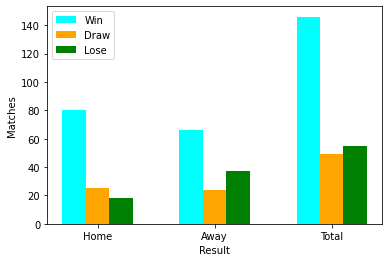

In [ ]:
x = np.arange(3)
y1 = [europe_or_south_america_home[0], europe_or_south_america_away[0], europe_or_south_america_total[0]]
y2 = [europe_or_south_america_home[1], europe_or_south_america_away[1], europe_or_south_america_total[1]]
y3 = [europe_or_south_america_home[2], europe_or_south_america_away[2], europe_or_south_america_total[2]]
width = 0.2

plt.bar(x-0.2, y1, width, color='cyan')
plt.bar(x, y2, width, color='orange')
plt.bar(x+0.2, y3, width, color='green')
plt.xticks(x, ['Home', 'Away', 'Total'])
plt.xlabel("Result")
plt.ylabel("Matches")
plt.legend(["Win", "Draw", "Lose"])
plt.show()

Even for the Away matches, where the European/South American teams should have a disadvantage, they still win most of the matches.

In [ ]:
# continent advantage for teams from Europe and South America

def create_continent_adv(dataframe):
    count = len(dataframe.index)
    for i in range(count):
        if dataframe.loc[i, "home_team_continent"] in ["Europe", "South America"] and dataframe.loc[i, "away_team_continent"] not in ["Europe", "South America"]:
            dataframe.loc[i, "continent_adv"] = 1
        elif dataframe.loc[i, "home_team_continent"] not in ["Europe", "South America"] and dataframe.loc[i, "away_team_continent"] in ["Europe", "South America"]:
            dataframe.loc[i, "continent_adv"] = -1
        else:
            dataframe.loc[i, "continent_adv"] = 0

create_continent_adv(training_matches)

In [ ]:
training_matches

,index,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,...,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score,home_adv,continent_adv
0,1,2004-09-04,Albania,Greece,Europe,Europe,94,14,0,0,...,70.0,90.0,67.5,59.0,74.5,82.8,83.7,85.2,1.0,0.0
1,2,2004-09-04,Austria,England,Europe,Europe,90,7,0,0,...,83.0,88.0,76.2,73.0,74.0,90.5,88.7,91.2,1.0,0.0
2,3,2004-09-04,Croatia,Hungary,Europe,Europe,25,76,0,0,...,77.0,74.0,80.5,78.7,79.0,71.8,75.7,70.2,1.0,0.0
3,4,2004-09-04,Denmark,Ukraine,Europe,Europe,15,87,0,0,...,82.0,77.0,79.5,85.0,81.5,67.8,81.7,65.8,1.0,0.0
4,5,2004-09-04,Iceland,Bulgaria,Europe,Europe,80,41,0,0,...,78.0,78.0,68.8,77.0,69.2,70.5,79.7,78.5,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3409,5634,2021-12-06,Tunisia,United Arab Emirates,Africa,Asia,29,70,1512,1350,...,71.0,70.0,70.8,72.3,74.0,63.0,64.3,67.0,0.0,0.0
3410,5635,2021-12-07,Morocco,Saudi Arabia,Africa,Asia,28,48,1525,1441,...,82.0,70.0,81.2,81.7,76.2,72.8,67.7,72.8,0.0,0.0
3411,5636,2021-12-07,Algeria,Egypt,Africa,Africa,32,45,1508,1449,...,78.0,73.0,78.0,81.0,78.0,71.0,79.3,70.8,0.0,0.0
3412,5638,2021-12-11,Morocco,Algeria,Africa,Africa,28,32,1525,1508,...,82.0,78.0,81.2,81.7,76.2,78.0,81.0,78.0,0.0,0.0


### 3. Team form/morale


The first approach was to sum up the points obtained by each team during the last 3 games.

In [ ]:
# team's form consisting of how many points(3 - win, 1 - draw, 0 - lose) did the team get in the last 3 matches

# dictionary to map game outcome to points earned by the home team
home_points = {
    "Win": 3,
    "Draw": 1,
    "Lose": 0
}

# dictionary to map game outcome to points earned by the away team
away_points = {
    "Win": 0,
    "Draw": 1,
    "Lose": 3
}

def get_team_points(team, match_index, dataframe, dataframe_extra):
    i = match_index - 1
    matches = 0
    points_sum = 0
    # searching for the last 3 matches of the team in the dataframe
    while i >= 0 and matches < 3:
        if dataframe.loc[i, "home_team"] == team:
            matches += 1
            points_sum += home_points[dataframe.loc[i, "home_team_result"]]
        if dataframe.loc[i, "away_team"] == team:
            matches += 1
            points_sum += away_points[dataframe.loc[i, "home_team_result"]]
        i -= 1
    
    # searching for the remaining matches (up to 3) of the team in the
    # extra dataframe (with older matches), if needed
    i = len(dataframe_extra.index) - 1
    while  i >= 0 and matches < 3:
        if dataframe_extra.loc[i, "home_team"] == team:
            matches += 1
            points_sum += home_points[dataframe_extra.loc[i, "home_team_result"]]
        if dataframe_extra.loc[i, "away_team"] == team:
            matches += 1
            points_sum += away_points[dataframe_extra.loc[i, "home_team_result"]]
        i -= 1
    
    return points_sum


def add_team_form(dataframe, dataframe_extra):
    count = len(dataframe.index)
    for i in range(count):
        dataframe.loc[i, "home_team_form"] = get_team_points(dataframe.loc[i, "home_team"], i, dataframe, dataframe_extra)
        dataframe.loc[i, "away_team_form"] = get_team_points(dataframe.loc[i, "away_team"], i, dataframe, dataframe_extra)

# add_team_form(training_matches, training_matches_before_2012)
# training_matches

The problem with this approach is that we are not able to generate this feature for the test set, because we would need to use the results of the matches before predicting them, which is not allowed. <br>

The second approach was to add a morale, given by the difference in fifa rank between the given team and the opponent teams from the last 3 games, supposing the team with the better rank is going to play better and have a better morale during the following matches. In the absence of knowing the results of future matches, this could act as a proxy for recent form, though would obviosly be less accurate.

In [ ]:
# new feature: team's morale

def get_team_morale(team, match_index, dataframe, dataframe_extra):
    i = match_index - 1
    matches = 0
    morale_sum = 0
    # searching for the last 3 matches of the team in the dataframe
    while i >= 0 and matches < 3:
        if dataframe.loc[i, "home_team"] == team:
            matches += 1
            morale_sum += (dataframe.loc[i, "away_team_fifa_rank"] - dataframe.loc[i, "home_team_fifa_rank"])
        if dataframe.loc[i, "away_team"] == team:
            matches += 1
            morale_sum += (dataframe.loc[i, "home_team_fifa_rank"] - dataframe.loc[i, "away_team_fifa_rank"])
        i -= 1
    
    # searching for the remaining matches (up to 3) of the team in the
    # extra dataframe (with older matches), if needed
    i = len(dataframe_extra.index) - 1
    while  i >= 0 and matches < 3:
        if dataframe_extra.loc[i, "home_team"] == team:
            matches += 1
            morale_sum += (dataframe_extra.loc[i, "away_team_fifa_rank"] - dataframe_extra.loc[i, "home_team_fifa_rank"])
        if dataframe_extra.loc[i, "away_team"] == team:
            matches += 1
            morale_sum += (dataframe_extra.loc[i, "home_team_fifa_rank"] - dataframe_extra.loc[i, "away_team_fifa_rank"])
        i -= 1
    
    return morale_sum


def add_team_morale(dataframe, dataframe_extra):
    count = len(dataframe.index)
    for i in range(count):
        dataframe.loc[i, "home_team_morale"] = get_team_morale(dataframe.loc[i, "home_team"], i, dataframe, dataframe_extra)
        dataframe.loc[i, "away_team_morale"] = get_team_morale(dataframe.loc[i, "away_team"], i, dataframe, dataframe_extra)

add_team_morale(training_matches, training_matches_before_2012)
training_matches

,index,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,...,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score,home_adv,continent_adv,home_team_morale,away_team_morale
0,1,2004-09-04,Albania,Greece,Europe,Europe,94,14,0,0,...,67.5,59.0,74.5,82.8,83.7,85.2,1.0,0.0,-123.0,69.0
1,2,2004-09-04,Austria,England,Europe,Europe,90,7,0,0,...,76.2,73.0,74.0,90.5,88.7,91.2,1.0,0.0,-179.0,178.0
2,3,2004-09-04,Croatia,Hungary,Europe,Europe,25,76,0,0,...,80.5,78.7,79.0,71.8,75.7,70.2,1.0,0.0,30.0,61.0
3,4,2004-09-04,Denmark,Ukraine,Europe,Europe,15,87,0,0,...,79.5,85.0,81.5,67.8,81.7,65.8,1.0,0.0,68.0,12.0
4,5,2004-09-04,Iceland,Bulgaria,Europe,Europe,80,41,0,0,...,68.8,77.0,69.2,70.5,79.7,78.5,1.0,0.0,-302.0,-33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3409,5634,2021-12-06,Tunisia,United Arab Emirates,Africa,Asia,29,70,1512,1350,...,70.8,72.3,74.0,63.0,64.3,67.0,0.0,0.0,42.0,-83.0
3410,5635,2021-12-07,Morocco,Saudi Arabia,Africa,Asia,28,48,1525,1441,...,81.2,81.7,76.2,72.8,67.7,72.8,0.0,0.0,165.0,-26.0
3411,5636,2021-12-07,Algeria,Egypt,Africa,Africa,32,45,1508,1449,...,78.0,81.0,78.0,71.0,79.3,70.8,0.0,0.0,64.0,188.0
3412,5638,2021-12-11,Morocco,Algeria,Africa,Africa,28,32,1525,1508,...,81.2,81.7,76.2,78.0,81.0,78.0,0.0,0.0,113.0,76.0


### 4. Other features

In [ ]:
# This block creates many features / formats existing ones
# Not all of these features where used in the end

# Puts dates in a more useful format
training_matches["date"] = pd.to_datetime(training_matches["date"])

#Encodes final result as a number
#training_matches["home_team_result"] = training_matches["home_team_result"].replace(['Lose', 'Draw', 'Win'], [-1, 0, 1])

# Encodes the home team as a number
training_matches["home_code"] = training_matches["home_team"].astype("category").cat.codes

# Encodes the away team as a number
training_matches["away_code"] = training_matches["away_team"].astype("category").cat.codes

# Encodes shoot out as a number
training_matches["shoot_out"] = training_matches["shoot_out"].replace(['No', 'Yes'], [0, 1])

# Encodes the tournament as a number
training_matches["tournament"] = training_matches["tournament"].astype("category").cat.codes

# Extracts the day of the week (as a number code 1-7)
training_matches["day"] = training_matches["date"].dt.dayofweek

# new feature: home rank - away rank
training_matches["rank_diff"] = training_matches["home_team_fifa_rank"] - training_matches["away_team_fifa_rank"]

# new feature: home fifa points - away fifa points
training_matches["fpoint_diff"] = training_matches["home_team_total_fifa_points"] - training_matches["away_team_total_fifa_points"]

# new feature: home offense - away defense
training_matches["ad_diff"] = training_matches["home_team_mean_offense_score"] - training_matches["away_team_mean_defense_score"]
# also tried a weighted sum between defense and goalkeeper score, but it worked worse
# training_matches["ad_diff"] = training_matches["home_team_mean_offense_score"] - (training_matches["away_team_mean_defense_score"] * 4.0 + training_matches["away_team_goalkeeper_score"]) / 5.0

# new feature: away offense - home defense
training_matches["da_diff"] = training_matches["away_team_mean_offense_score"] - training_matches["home_team_mean_defense_score"]
# also tried a weighted sum between defense and goalkeeper score, but it worked worse
# training_matches["da_diff"] = training_matches["away_team_mean_offense_score"] - (training_matches["home_team_mean_defense_score"] * 4.0 + training_matches["home_team_goalkeeper_score"]) / 5.0

# new feature: home midfield - away midfield
training_matches["mm_diff"] = training_matches["home_team_mean_midfield_score"] - training_matches["away_team_mean_midfield_score"]

# new feature: ad_diff - da_diff
training_matches["adda_diff"] = training_matches["ad_diff"] - training_matches["da_diff"]

# new feature: home morale - away morale
training_matches["morale_diff"] = training_matches["home_team_morale"] - training_matches["away_team_morale"]

#show datatypes of all features
#features which we wish to use are now numerical datatypes
training_matches.dtypes

index                                     int64
date                             datetime64[ns]
home_team                                object
away_team                                object
home_team_continent                      object
away_team_continent                      object
home_team_fifa_rank                       int64
away_team_fifa_rank                       int64
home_team_total_fifa_points               int64
away_team_total_fifa_points               int64
home_team_score                           int64
away_team_score                           int64
tournament                                 int8
city                                     object
country                                  object
neutral_location                           bool
shoot_out                                 int64
home_team_result                         object
home_team_goalkeeper_score              float64
away_team_goalkeeper_score              float64
home_team_mean_defense_score            

## Plots to show correlations between features

Here we create large scatter plots which show relationships between multiple features as well as match outcome. Several plots are given here, however more were generated by simply altering the feature names in the plotting code.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f02d2a57430>,
      dtype=object)

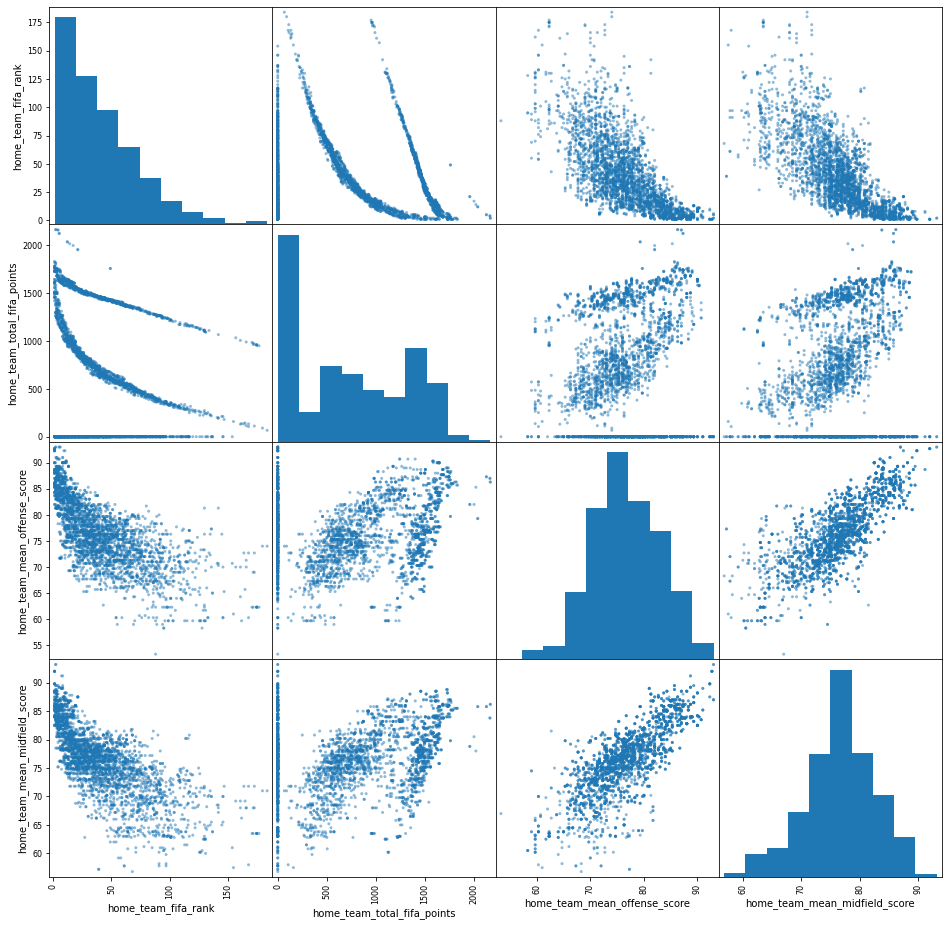

In [ ]:
scatter_matrix(training_matches[['home_team_fifa_rank', 'home_team_total_fifa_points', 
                                 'home_team_mean_offense_score', 'home_team_mean_midfield_score',
                                 'home_team_result']], figsize=(16,16))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f02d2435730>,
      dtype=object)

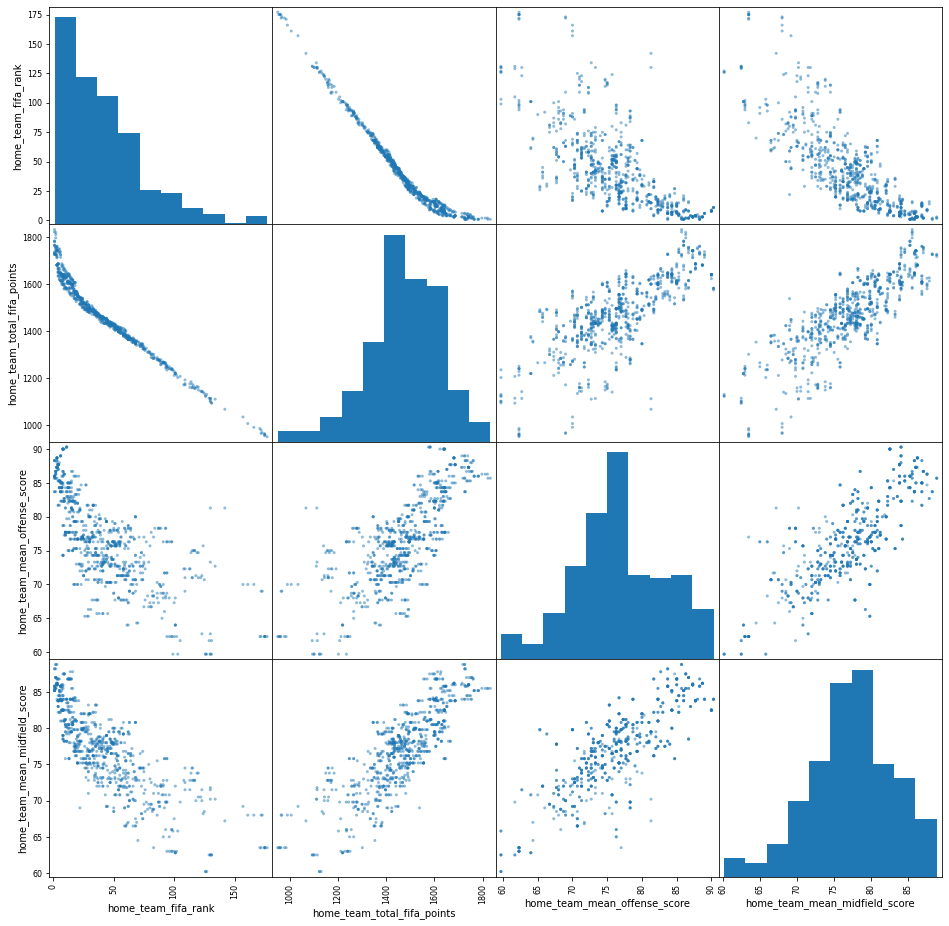

In [ ]:
from2018 = training_matches[training_matches["date"] > '2018-08-01']

scatter_matrix(from2018[['home_team_fifa_rank', 'home_team_total_fifa_points', 
                                 'home_team_mean_offense_score', 'home_team_mean_midfield_score',
                                 'home_team_result']], figsize=(16,16))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f02d2476190>,
      dtype=object)

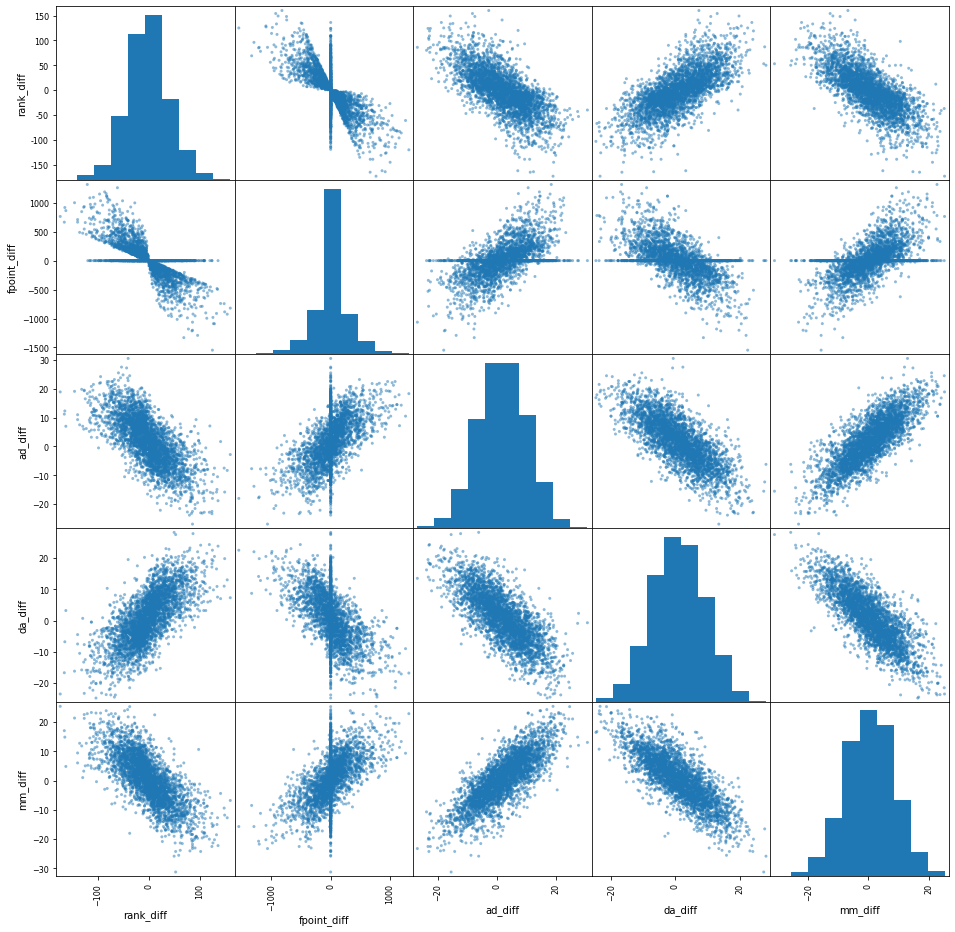

In [ ]:
scatter_matrix(training_matches[['rank_diff', 'fpoint_diff', 'ad_diff',
                                'da_diff', 'mm_diff', 'home_team_result']], figsize=(16,16))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f02d1787640>,
      dtype=object)

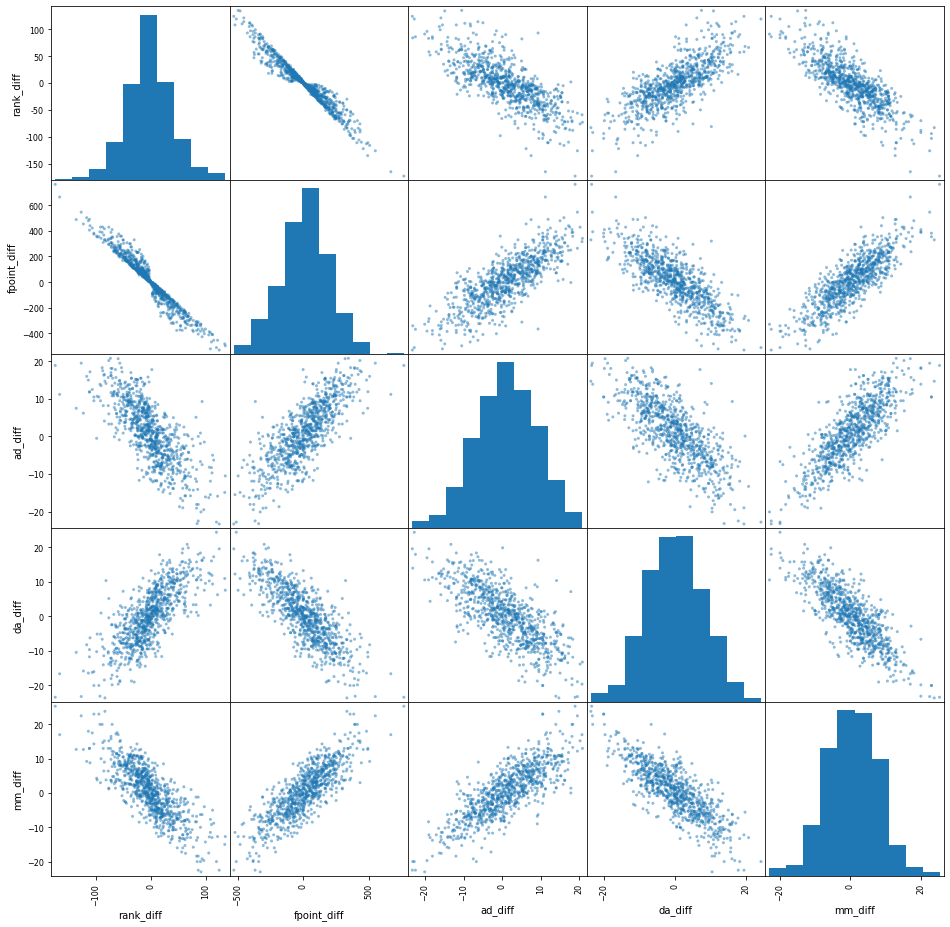

In [ ]:
scatter_matrix(from2018[['rank_diff', 'fpoint_diff', 'ad_diff',
                                'da_diff', 'mm_diff', 'home_team_result']], figsize=(16,16))

## Adding all features to the testing dataframe

### 1. Continent

In [ ]:
# adding the continent that corresponds to each country by creating a dictionary 
# for mapping countries to continents

def country_continent_map(dataframe):
    cc_map = {}
    count = len(dataframe.index)
    for i in range(count):
        if dataframe.loc[i, "home_team"] not in cc_map:
            cc_map[dataframe.loc[i, "home_team"]] = dataframe.loc[i, "home_team_continent"]
        if dataframe.loc[i, "away_team"] not in cc_map:
            cc_map[dataframe.loc[i, "away_team"]] = dataframe.loc[i, "away_team_continent"]
    return cc_map

country_to_continent_map = country_continent_map(training_matches)

In [ ]:
def adding_continent(dataframe, country_to_continent_map):
    count = len(dataframe.index)
    for i in range(count):
        dataframe.loc[i, "home_team_continent"] = country_to_continent_map[dataframe.loc[i, "home_team"]]
        dataframe.loc[i, "away_team_continent"] = country_to_continent_map[dataframe.loc[i, "away_team"]]

adding_continent(testing_matches, country_to_continent_map)
testing_matches

,date,home_team,away_team,home_team_result,home_team_continent,away_team_continent
0,2022-01-02,Gabon,Burkina Faso,Lose,Africa,Africa
1,2022-01-05,Algeria,Ghana,Win,Africa,Africa
2,2022-01-09,Cameroon,Burkina Faso,Win,Africa,Africa
3,2022-01-10,Senegal,Zimbabwe,Win,Africa,Africa
4,2022-01-10,Morocco,Ghana,Win,Africa,Africa
...,...,...,...,...,...,...
242,2022-06-14,Bosnia and Herzegovina,Finland,Win,Europe,Europe
243,2022-06-14,Romania,Montenegro,Lose,Europe,Europe
244,2022-06-14,Chile,Ghana,Lose,South America,Africa
245,2022-06-14,Japan,Tunisia,Lose,Asia,Africa


### 2. Fifa rank, Fifa points, GK score, DEF score, MID score, OFF score

To add this features we check for the most recent match of each team because the testing is over a short period (less than 1 year), so the teams would not be changing to much.

In [ ]:
# create empty columns for each feature in the test dataframe

testing_matches["home_team_fifa_rank"] = np.nan
testing_matches["away_team_fifa_rank"] = np.nan
testing_matches["home_team_total_fifa_points"] = np.nan
testing_matches["away_team_total_fifa_points"] = np.nan
testing_matches["home_team_goalkeeper_score"] = np.nan
testing_matches["away_team_goalkeeper_score"] = np.nan
testing_matches["home_team_mean_defense_score"] = np.nan
testing_matches["away_team_mean_defense_score"] = np.nan
testing_matches["home_team_mean_midfield_score"] = np.nan
testing_matches["away_team_mean_midfield_score"] = np.nan
testing_matches["home_team_mean_offense_score"] = np.nan
testing_matches["away_team_mean_offense_score"] = np.nan

In [ ]:
# for each team in the testframe (2022 matches) we search for the most recent match
# in the dataframe (before 2022 matches)

def adding_country_features(dataframe, testframe):
    countD = len(dataframe.index)
    countT = len(testframe.index)

    for i in range(countT):
      
        # if is enough to check that only one feature is missing 
        # because we are completing all of them together
        if pd.isna(testframe.loc[i, "home_team_fifa_rank"]):
            j = countD - 1

            # searching for the most recent match where the team played either as a home or away team
            while j >= 0 and (dataframe.loc[j, "home_team"] != testframe.loc[i, "home_team"] and dataframe.loc[j, "away_team"] != testframe.loc[i, "home_team"]):
                j -= 1

            if dataframe.loc[j, "home_team"] == testframe.loc[i, "home_team"]:
                testframe.loc[i, "home_team_fifa_rank"] = dataframe.loc[j, "home_team_fifa_rank"]
                testframe.loc[i, "home_team_total_fifa_points"] = dataframe.loc[j, "home_team_total_fifa_points"]
                testframe.loc[i, "home_team_goalkeeper_score"] = dataframe.loc[j, "home_team_goalkeeper_score"]
                testframe.loc[i, "home_team_mean_defense_score"] = dataframe.loc[j, "home_team_mean_defense_score"]
                testframe.loc[i, "home_team_mean_midfield_score"] = dataframe.loc[j, "home_team_mean_midfield_score"]
                testframe.loc[i, "home_team_mean_offense_score"] = dataframe.loc[j, "home_team_mean_offense_score"]
            elif dataframe.loc[j, "away_team"] == testframe.loc[i, "home_team"]:
                testframe.loc[i, "home_team_fifa_rank"] = dataframe.loc[j, "away_team_fifa_rank"]
                testframe.loc[i, "home_team_total_fifa_points"] = dataframe.loc[j, "away_team_total_fifa_points"]
                testframe.loc[i, "home_team_goalkeeper_score"] = dataframe.loc[j, "away_team_goalkeeper_score"]
                testframe.loc[i, "home_team_mean_defense_score"] = dataframe.loc[j, "away_team_mean_defense_score"]
                testframe.loc[i, "home_team_mean_midfield_score"] = dataframe.loc[j, "away_team_mean_midfield_score"]
                testframe.loc[i, "home_team_mean_offense_score"] = dataframe.loc[j, "away_team_mean_offense_score"]
        
        # if is enough to check that only one feature is missing 
        # because we are completing all of them together
        if pd.isna(testframe.loc[i, "away_team_fifa_rank"]):
            j = countD - 1

            # searching for the most recent match where the team played either as a home or away team
            while j >= 0 and (dataframe.loc[j, "home_team"] != testframe.loc[i, "away_team"] and dataframe.loc[j, "away_team"] != testframe.loc[i, "away_team"]):
                j -= 1

            if dataframe.loc[j, "home_team"] == testframe.loc[i, "away_team"]:
                testframe.loc[i, "away_team_fifa_rank"] = dataframe.loc[j, "home_team_fifa_rank"]
                testframe.loc[i, "away_team_total_fifa_points"] = dataframe.loc[j, "home_team_total_fifa_points"]
                testframe.loc[i, "away_team_goalkeeper_score"] = dataframe.loc[j, "home_team_goalkeeper_score"]
                testframe.loc[i, "away_team_mean_defense_score"] = dataframe.loc[j, "home_team_mean_defense_score"]
                testframe.loc[i, "away_team_mean_midfield_score"] = dataframe.loc[j, "home_team_mean_midfield_score"]
                testframe.loc[i, "away_team_mean_offense_score"] = dataframe.loc[j, "home_team_mean_offense_score"]
            elif dataframe.loc[j, "away_team"] == testframe.loc[i, "away_team"]:
                testframe.loc[i, "away_team_fifa_rank"] = dataframe.loc[j, "away_team_fifa_rank"]
                testframe.loc[i, "away_team_total_fifa_points"] = dataframe.loc[j, "away_team_total_fifa_points"]
                testframe.loc[i, "away_team_goalkeeper_score"] = dataframe.loc[j, "away_team_goalkeeper_score"]
                testframe.loc[i, "away_team_mean_defense_score"] = dataframe.loc[j, "away_team_mean_defense_score"]
                testframe.loc[i, "away_team_mean_midfield_score"] = dataframe.loc[j, "away_team_mean_midfield_score"]
                testframe.loc[i, "away_team_mean_offense_score"] = dataframe.loc[j, "away_team_mean_offense_score"]

adding_country_features(training_matches, testing_matches)
testing_matches

,date,home_team,away_team,home_team_result,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,away_team_mean_defense_score,home_team_mean_midfield_score,away_team_mean_midfield_score,home_team_mean_offense_score,away_team_mean_offense_score
0,2022-01-02,Gabon,Burkina Faso,Lose,Africa,Africa,86.0,61.0,1280.0,1400.0,66.0,73.0,70.2,69.5,75.5,67.0,70.3,71.7
1,2022-01-05,Algeria,Ghana,Win,Africa,Africa,32.0,52.0,1508.0,1424.0,78.0,74.0,78.0,75.5,78.0,78.2,81.0,76.0
2,2022-01-09,Cameroon,Burkina Faso,Win,Africa,Africa,54.0,61.0,1418.0,1400.0,67.0,73.0,76.8,69.5,75.0,67.0,77.7,71.7
3,2022-01-10,Senegal,Zimbabwe,Win,Africa,Africa,20.0,118.0,1564.0,1147.0,83.0,68.0,79.0,65.0,79.0,72.8,80.7,72.3
4,2022-01-10,Morocco,Ghana,Win,Africa,Africa,28.0,52.0,1525.0,1424.0,82.0,74.0,81.2,75.5,76.2,78.2,81.7,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,2022-06-14,Bosnia and Herzegovina,Finland,Win,Europe,Europe,56.0,60.0,1414.0,1403.0,76.0,83.0,74.2,70.0,78.0,73.5,77.0,72.3
243,2022-06-14,Romania,Montenegro,Lose,Europe,Europe,41.0,73.0,1451.0,1346.0,77.0,65.0,73.5,76.2,75.0,68.2,73.7,74.7
244,2022-06-14,Chile,Ghana,Lose,South America,Africa,21.0,52.0,1546.0,1424.0,79.0,74.0,75.5,75.5,78.2,78.2,76.7,76.0
245,2022-06-14,Japan,Tunisia,Lose,Asia,Africa,26.0,29.0,1520.0,1512.0,73.0,71.0,75.2,70.8,77.5,74.0,75.0,72.3


### 3. Engineered features

In [ ]:
create_continent_adv(testing_matches)

add_team_morale(testing_matches, training_matches)

testing_matches["rank_diff"] = testing_matches["home_team_fifa_rank"] - testing_matches["away_team_fifa_rank"]

testing_matches["fpoint_diff"] = testing_matches["home_team_total_fifa_points"] - testing_matches["away_team_total_fifa_points"]

testing_matches["ad_diff"] = testing_matches["home_team_mean_offense_score"] - testing_matches["away_team_mean_defense_score"]

testing_matches["da_diff"] = testing_matches["away_team_mean_offense_score"] - testing_matches["home_team_mean_defense_score"]

testing_matches["mm_diff"] = testing_matches["home_team_mean_midfield_score"] - testing_matches["away_team_mean_midfield_score"]

testing_matches["adda_diff"] = testing_matches["ad_diff"] - testing_matches["da_diff"]

testing_matches["morale_diff"] = testing_matches["home_team_morale"] - testing_matches["away_team_morale"]

testing_matches

,date,home_team,away_team,home_team_result,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,...,continent_adv,home_team_morale,away_team_morale,rank_diff,fpoint_diff,ad_diff,da_diff,mm_diff,adda_diff,morale_diff
0,2022-01-02,Gabon,Burkina Faso,Lose,Africa,Africa,86.0,61.0,1280.0,1400.0,...,0.0,-20.0,-38.0,25.0,-120.0,0.8,1.5,8.5,-0.7,18.0
1,2022-01-05,Algeria,Ghana,Win,Africa,Africa,32.0,52.0,1508.0,1424.0,...,0.0,6.0,134.0,-20.0,84.0,5.5,-2.0,-0.2,7.5,-128.0
2,2022-01-09,Cameroon,Burkina Faso,Win,Africa,Africa,54.0,61.0,1418.0,1400.0,...,0.0,32.0,-38.0,-7.0,18.0,8.2,-5.1,8.0,13.3,70.0
3,2022-01-10,Senegal,Zimbabwe,Win,Africa,Africa,20.0,118.0,1564.0,1147.0,...,0.0,263.0,-172.0,-98.0,417.0,15.7,-6.7,6.2,22.4,435.0
4,2022-01-10,Morocco,Ghana,Win,Africa,Africa,28.0,52.0,1525.0,1424.0,...,0.0,74.0,54.0,-24.0,101.0,6.2,-5.2,-2.0,11.4,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,2022-06-14,Bosnia and Herzegovina,Finland,Win,Europe,Europe,56.0,60.0,1414.0,1403.0,...,0.0,6.0,-10.0,-4.0,11.0,7.0,-1.9,4.5,8.9,16.0
243,2022-06-14,Romania,Montenegro,Lose,Europe,Europe,41.0,73.0,1451.0,1346.0,...,0.0,66.0,-62.0,-32.0,105.0,-2.5,1.2,6.8,-3.7,128.0
244,2022-06-14,Chile,Ghana,Lose,South America,Africa,21.0,52.0,1546.0,1424.0,...,1.0,16.0,6.0,-31.0,122.0,1.2,0.5,0.0,0.7,10.0
245,2022-06-14,Japan,Tunisia,Lose,Asia,Africa,26.0,29.0,1520.0,1512.0,...,0.0,14.0,42.0,-3.0,8.0,4.2,-2.9,3.5,7.1,-28.0


## Dimension reduction using PCA

As it can be observed in the previous plots, for each team, the GK, DEF, MID, OFF scores are generally correlated. Therefore, we used PCA to reduce those 4 features to only 1.

In [ ]:
score_home_teams = training_matches[["home_team_goalkeeper_score", "home_team_mean_defense_score",
                                 "home_team_mean_midfield_score", "home_team_mean_offense_score"]]
score_home_teams_testing = testing_matches[["home_team_goalkeeper_score", "home_team_mean_defense_score",
                                         "home_team_mean_midfield_score", "home_team_mean_offense_score"]]

score_away_teams = training_matches[["away_team_goalkeeper_score", "away_team_mean_defense_score",
                                 "away_team_mean_midfield_score", "away_team_mean_offense_score"]]
score_away_teams_testing = testing_matches[["away_team_goalkeeper_score", "away_team_mean_defense_score",
                                        "away_team_mean_midfield_score", "away_team_mean_offense_score"]]


print("Initial size of traning/testing feature set for the home teams scores:", score_home_teams.shape, score_home_teams_testing.shape)
print("Initial size of traning/testing feature set for the away teams scores:", score_away_teams.shape, score_away_teams_testing.shape)

# scale the data to mean = 0 and standard deviation = 1
scaler = StandardScaler()
score_home_teams = scaler.fit_transform(score_home_teams)
score_home_teams_testing = scaler.transform(score_home_teams_testing)
score_away_teams = scaler.fit_transform(score_away_teams)
score_away_teams_testing = scaler.transform(score_away_teams_testing)

# projecting to reduce dimensionality from 4 to 1
pca = PCA(n_components=1)
score_home_teams = pca.fit_transform(score_home_teams)
score_home_teams_testing = pca.transform(score_home_teams_testing)
score_away_teams = pca.fit_transform(score_away_teams)
score_away_teams_testing = pca.transform(score_away_teams_testing)

print("Modified size of traning/testing feature set for the home teams scores:", score_home_teams.shape, score_home_teams_testing.shape)
print("Modified size of traning/testing feature set for the away teams scores:", score_away_teams.shape, score_away_teams_testing.shape)

Initial size of traning/testing feature set for the home teams scores: (3414, 4) (247, 4)
Initial size of traning/testing feature set for the away teams scores: (3414, 4) (247, 4)
Modified size of traning/testing feature set for the home teams scores: (3414, 1) (247, 1)
Modified size of traning/testing feature set for the away teams scores: (3414, 1) (247, 1)


Adding the normalized scores for each team obtained after applying PCA.


In [ ]:
training_matches["home_normalized_score"] = score_home_teams
testing_matches["home_normalized_score"] = score_home_teams_testing

training_matches["away_normalized_score"] = score_away_teams
testing_matches["away_normalized_score"] = score_away_teams_testing

Instead of using the "home_normalized_score" and "away_normalized_score" as features, we use their difference ("score_diff")

In [ ]:
# new feature: home score - away score
training_matches["score_diff"] = training_matches["home_normalized_score"] - training_matches["away_normalized_score"]
testing_matches["score_diff"] = testing_matches["home_normalized_score"] - testing_matches["away_normalized_score"]

In [ ]:
training_matches

,index,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,...,rank_diff,fpoint_diff,ad_diff,da_diff,mm_diff,adda_diff,morale_diff,home_normalized_score,away_normalized_score,score_diff
0,1,2004-09-04,Albania,Greece,Europe,Europe,94,14,0,0,...,80,0,-23.8,16.2,-10.7,-40.0,-192.0,2.602955,-2.905451,5.508406
1,2,2004-09-04,Austria,England,Europe,Europe,90,7,0,0,...,83,0,-17.5,12.5,-17.2,-30.0,-357.0,0.048863,-4.392418,4.441281
2,3,2004-09-04,Croatia,Hungary,Europe,Europe,25,76,0,0,...,-51,0,6.9,-4.8,8.8,11.7,-31.0,-0.858543,0.912973,-1.771516
3,4,2004-09-04,Denmark,Ukraine,Europe,Europe,15,87,0,0,...,-72,0,17.2,2.2,15.7,15.0,56.0,-1.766531,0.999250,-2.765781
4,5,2004-09-04,Iceland,Bulgaria,Europe,Europe,80,41,0,0,...,39,0,6.5,10.9,-9.3,-4.4,-269.0,1.075809,-0.238624,1.314433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3409,5634,2021-12-06,Tunisia,United Arab Emirates,Africa,Asia,29,70,1512,1350,...,-41,162,9.3,-6.5,7.0,15.8,125.0,1.258544,3.104798,-1.846254
3410,5635,2021-12-07,Morocco,Saudi Arabia,Africa,Asia,28,48,1525,1441,...,-20,84,8.9,-13.5,3.4,22.4,191.0,-1.199919,1.464245,-2.664164
3411,5636,2021-12-07,Algeria,Egypt,Africa,Africa,32,45,1508,1449,...,-13,59,10.0,1.3,7.2,8.7,-124.0,-0.793117,0.700692,-1.493809
3412,5638,2021-12-11,Morocco,Algeria,Africa,Africa,28,32,1525,1508,...,-4,17,3.7,-0.2,-1.8,3.9,37.0,-1.199919,-0.961440,-0.238479


# Model Training & Validation

To start, we set up what our predictors (chosen features) are and run a variety of models on a simply defined validation set (matches during/after 2020 are the validation set). Obviously, a train-test split like this has its drawbacks in validation, but we proceed to cross validation afterwards and using this format first was helpful for feature selection. We edited the predictors throughout to inform feature selection, making use of the accuracy scores, confision matrices, and .feature_importances_ from the random forest classifier. 

In [ ]:
#Selection of features used in the models
predictors = ["rank_diff", "adda_diff", "morale_diff", "score_diff"]

categorical_predictors = ["continent_adv"]

In [ ]:
# We use a standard scaler to standardise data under our predictor features
# Which is fine - some models require it and 
# other nonlinear models (e.g. random forest) are unaffected
# Categorical predictors don't require regularisation and are 
# appended to 'predictors' afterwards
scaler = StandardScaler()
scaler.fit(training_matches[predictors])

training_matches[predictors] = scaler.transform(training_matches[predictors])
testing_matches[predictors] = scaler.transform(testing_matches[predictors])

predictors = predictors + categorical_predictors

In [ ]:
train = training_matches[training_matches["date"] < '2020-01-01']

test = training_matches[training_matches["date"] > '2020-01-01']

In [ ]:
#Random Forest Classifier
randf = RandomForestClassifier(n_estimators=300, min_samples_split=0.25, random_state=7)

In [ ]:
randf.fit(train[predictors], train["home_team_result"])

RandomForestClassifier(min_samples_split=0.25, n_estimators=300, random_state=7)

In [ ]:
predictions = randf.predict(test[predictors])

In [ ]:
model_acc = accuracy_score(test["home_team_result"], predictions)
model_acc

0.5722772277227722

In [ ]:
juxtaposed = pd.DataFrame(dict(Real=test["home_team_result"], Modelled=predictions))

In [ ]:
pd.crosstab(index=juxtaposed["Real"], columns=juxtaposed["Modelled"])

Modelled,Lose,Win
Real,,
Draw,58,70
Lose,105,44
Win,44,184


In [ ]:
cm = confusion_matrix(test["home_team_result"], predictions)
print (cm)

[[  0  58  70]
 [  0 105  44]
 [  0  44 184]]


In [ ]:
#Uses .feature_importances_ to show which predictors were most influential (higher scores = more influential)
#The importances printed below correspond to the predictors we defined above
ourRFfit = randf.fit(train[predictors], train["home_team_result"])

importances = ourRFfit.feature_importances_
importances

array([1.98586051e-01, 3.03191702e-01, 5.93450638e-02, 4.38606681e-01,
       2.70501704e-04])

In [ ]:
#Decision Tree Classifier
dtree = DecisionTreeClassifier(criterion = 'entropy', random_state = 7)
dtree.fit(train[predictors], train["home_team_result"])

y_pred = dtree.predict(test[predictors])

cm = confusion_matrix(test["home_team_result"], y_pred)
print (cm)
acc_dtree = accuracy_score(test["home_team_result"], y_pred)
print (acc_dtree)

[[ 38  34  56]
 [ 57  39  53]
 [ 50  42 136]]
0.42178217821782177


In [ ]:
#AdaBoost Classifier
adaboost = AdaBoostClassifier()
adaboost.fit(train[predictors], train["home_team_result"])

y_pred_adaboost = adaboost.predict(test[predictors])


cm = confusion_matrix(test["home_team_result"], y_pred_adaboost)
print (cm)
acc_adaboost = accuracy_score(test["home_team_result"], y_pred_adaboost)
print (acc_adaboost)


[[  0  59  69]
 [  0 107  42]
 [  0  51 177]]
0.5623762376237624


In [ ]:
#Quadratic Discriminant Analysis
quad = QuadraticDiscriminantAnalysis()
quad.fit(train[predictors], train["home_team_result"])

y_pred_quad = quad.predict(test[predictors])

cm = confusion_matrix(test["home_team_result"], y_pred_quad)
print (cm)
acc_quad = accuracy_score(test["home_team_result"], y_pred_quad)
print (acc_quad)

[[  2  46  80]
 [  1  88  60]
 [  2  29 197]]
0.5683168316831683


In [ ]:
#Multi-Layer Perceptron
multilp = MLPClassifier(alpha=0.25, max_iter=2000, hidden_layer_sizes = (1000,), random_state = 7)
multilp.fit(train[predictors], train["home_team_result"])

y_pred_multilp = multilp.predict(test[predictors])

cm = confusion_matrix(test["home_team_result"], y_pred_multilp)
print (cm)
acc_multilp = accuracy_score(test["home_team_result"], y_pred_multilp)
print (acc_multilp)

[[  0  52  76]
 [  0  91  58]
 [  0  35 193]]
0.5623762376237624


In [ ]:
#Support Vector Classifier
svc_rbf = SVC(kernel = 'rbf', C=1, random_state = 0)
svc_rbf.fit(train[predictors], train["home_team_result"])

y_pred_svc_rbf = svc_rbf.predict(test[predictors])

cm = confusion_matrix(test["home_team_result"], y_pred_svc_rbf)
print (cm)
acc_svc_rbf = accuracy_score(test["home_team_result"], y_pred_svc_rbf)
print (acc_svc_rbf)

[[  0  55  73]
 [  0  90  59]
 [  0  37 191]]
0.5564356435643565


In [ ]:
#K Nearest Neighbours
knear = KNeighborsClassifier(n_neighbors = 700, metric = 'minkowski', p = 2)
knear.fit(train[predictors], train["home_team_result"])

y_pred_knear = knear.predict(test[predictors])

confmat_knear = confusion_matrix(test["home_team_result"], y_pred_knear)
print (confmat_knear)
acc_knear = accuracy_score(test["home_team_result"], y_pred_knear)
print (acc_knear)

[[  0  53  75]
 [  0  94  55]
 [  0  34 194]]
0.5702970297029702


In [ ]:
#Logistic Regression
lr = LogisticRegression(random_state = 7)
lr.fit(train[predictors], train["home_team_result"])

y_pred_logreg = lr.predict(test[predictors])

confmat_lr = confusion_matrix(test["home_team_result"], y_pred_logreg)
print(confmat_lr)
acc_logreg = accuracy_score(test["home_team_result"], y_pred_logreg)
print (acc_logreg)

[[  0  44  84]
 [  0  85  64]
 [  0  32 196]]
0.5564356435643565


## Cross Validation

We now run cross validation to give more relevant accuracy scores and utilise more of the training data to inform model selection

In [ ]:
# SVC
scores = cross_val_score(svc_rbf,train[predictors], train["home_team_result"], cv=10)
print(scores.mean())
print(scores.std())

0.5723687640715724
0.019780826102737327


In [ ]:
# Logistic Regression
scores = cross_val_score(lr,train[predictors], train["home_team_result"], cv=10)
print(scores.mean())
print(scores.std())

0.5706481810641071
0.01665865573746418


In [ ]:
# K Nearest Neighbours
scores = cross_val_score(knear,train[predictors], train["home_team_result"], cv=10)
print(scores.mean())
print(scores.std())

0.5699597108662163
0.02066533359493811


In [ ]:
# Multilayer Perceptron
scores = cross_val_score(multilp,train[predictors], train["home_team_result"], cv=10)
print(scores.mean())
print(scores.std())

0.5730548643204171
0.01783912176979305


In [ ]:
# Quadratic Discriminant Analysis
scores = cross_val_score(quad,train[predictors], train["home_team_result"], cv=10)
print(scores.mean())
print(scores.std())

0.5661855670103092
0.021831017672678296


In [ ]:
# Random Forest
scores = cross_val_score(randf,train[predictors], train["home_team_result"], cv=10)
print(scores.mean())
print(scores.std())

0.5682450527313663
0.019691776560181135


In [ ]:
# AdaBoost
scores = cross_val_score(adaboost,train[predictors], train["home_team_result"], cv=10)
print(scores.mean())
print(scores.std())

0.547615831259628
0.016064828620935483


In [ ]:
# Decision Tree
scores = cross_val_score(dtree,train[predictors], train["home_team_result"], cv=10)
print(scores.mean())
print(scores.std())

0.43624600071098474
0.0212299929724291


## Hyperparameter tuning

For several of the model types which were used, hyperparameters require tuning for an optimal result to be produced. We do this here so we can make a fair comparison of these models with others. In practice the reccommended hyperparameters here dont provide large/any performance boost since manual tinkering in the above ccode allowed us to find roughly optimal values prior to this.

### Random Forest Classifier

Text(0.5, 0, 'No. Estimators')

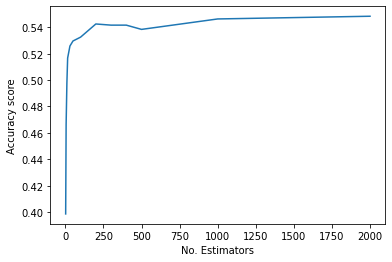

In [ ]:
#This first cell looks at tuning using cross validation accuracy scores
#but afterwards we use singular train and test sets so over/underfitting 
#can be seen more obviously
num_estimators = [2, 5, 10, 15, 30, 50, 100, 200, 300, 400, 500, 1000, 2000]

results = []

for est in num_estimators:
    randf = RandomForestClassifier(n_estimators=est, n_jobs=-1)
    scores = cross_val_score(randf,training_matches[predictors], training_matches["home_team_result"], cv=5, scoring='accuracy')
    results.append(scores.mean())

plt.plot(num_estimators, results)
plt.ylabel('Accuracy score')
plt.xlabel('No. Estimators')

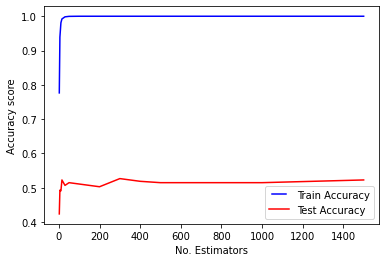

In [ ]:
num_estimators = [2, 5, 10, 15, 30, 50, 100, 200, 300, 400, 500, 1000, 1500]

results_train = []
results_test = []

for est in num_estimators:
    randf = RandomForestClassifier(n_estimators=est, n_jobs=-1)
    randf.fit(train[predictors], train["home_team_result"])
    
    preds_train = randf.predict(train[predictors])
    model_acc_train = accuracy_score(train["home_team_result"], preds_train)
    
    results_train.append(model_acc_train)
    
    
    preds_test = randf.predict(test[predictors])
    model_acc_test = accuracy_score(test["home_team_result"], preds_test)
    
    results_test.append(model_acc_test)
    
    #print(results_train)
    #print(results_test)
    

firstline, = plt.plot(num_estimators, results_train, 'b', label="Train Accuracy")
secondline, = plt.plot(num_estimators, results_test, 'r', label="Test Accuracy")
plt.legend(handler_map={firstline: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('No. Estimators')
plt.show()

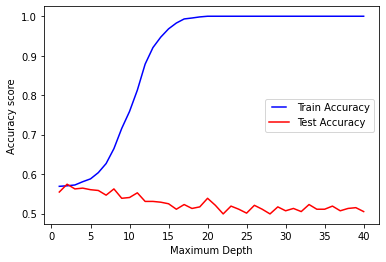

In [ ]:
depths = np.linspace(1, 40, 40, endpoint=True)

results_train = []
results_test = []

for dep in depths:
    randf = RandomForestClassifier(max_depth = dep, n_jobs=-1)
    randf.fit(train[predictors], train["home_team_result"])
    
    preds_train = randf.predict(train[predictors])
    model_acc_train = accuracy_score(train["home_team_result"], preds_train)
    
    results_train.append(model_acc_train)
    
    
    preds_test = randf.predict(test[predictors])
    model_acc_test = accuracy_score(test["home_team_result"], preds_test)
    
    results_test.append(model_acc_test)
    
    
firstline, = plt.plot(depths, results_train, 'b', label="Train Accuracy")
secondline, = plt.plot(depths, results_test, 'r', label="Test Accuracy")
plt.legend(handler_map={firstline: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('Maximum Depth')
plt.show()

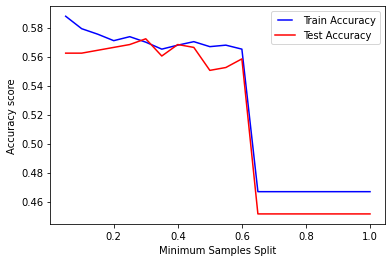

In [ ]:
splits = np.linspace(0.05, 1.0, 20, endpoint=True)

results_train = []
results_test = []

for split in splits:
    
    randf = RandomForestClassifier(min_samples_split=split, n_jobs=-1)
    randf.fit(train[predictors], train["home_team_result"])
    
    preds_train = randf.predict(train[predictors])
    model_acc_train = accuracy_score(train["home_team_result"], preds_train)
    
    results_train.append(model_acc_train)
    
    
    preds_test = randf.predict(test[predictors])
    model_acc_test = accuracy_score(test["home_team_result"], preds_test)
    
    results_test.append(model_acc_test)
    
    
firstline, = plt.plot(splits, results_train, 'b', label="Train Accuracy")
secondline, = plt.plot(splits, results_test, 'r', label="Test Accuracy")
plt.legend(handler_map={firstline: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('Minimum Samples Split')
plt.show()
    

In [ ]:
randf = RandomForestClassifier(min_samples_split=0.15, n_estimators=100, max_depth = 3, n_jobs=-1)
scores = cross_val_score(randf,training_matches[predictors], training_matches["home_team_result"], cv=10, scoring='accuracy')
print(scores.mean())
print(scores.std())

0.5653341565056336
0.01739602761335865


### Multi-Layer Perceptron
N.B. code the below cell is not ours, credit to source: https://panjeh.medium.com/scikit-learn-hyperparameter-optimization-for-mlpclassifier-4d670413042b

The GridSearchCV method allows us to efficiently tune hyperparameters here, which is a more complex task for MLP's

In [ ]:
mlp_gs = MLPClassifier(max_iter=500)
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
clf.fit(train[predictors], train["home_team_result"]) 

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=500), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(10, 30, 10), (20,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [ ]:
#Shows the most optimal parameters found
print(clf.best_params_)

{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'adaptive', 'solver': 'sgd'}


In [ ]:
mlp2 = MLPClassifier(activation = 'tanh', alpha = 0.05, hidden_layer_sizes = (20,),
                       learning_rate = 'constant', solver = 'adam', max_iter=500)

scores = cross_val_score(mlp2,training_matches[predictors], training_matches["home_team_result"], cv=5, scoring='accuracy')
print(scores.mean())
print(scores.std())

0.5720596128001787
0.014227074908964419


### K-Nearest Neighbours

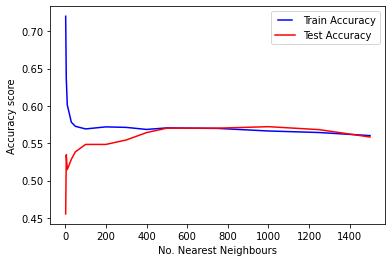

In [ ]:
neighbours = [2, 5, 10, 30, 50, 100, 200, 300, 400, 500, 750, 1000, 1250, 1500]

results_train = []
results_test = []

for nb in neighbours:
    
    knear = knear = KNeighborsClassifier(n_neighbors = nb, metric = 'minkowski', p = 2)
    knear.fit(train[predictors], train["home_team_result"])
    
    preds_train = knear.predict(train[predictors])
    model_acc_train = accuracy_score(train["home_team_result"], preds_train)
    
    results_train.append(model_acc_train)
    
    
    preds_test = knear.predict(test[predictors])
    model_acc_test = accuracy_score(test["home_team_result"], preds_test)
    
    results_test.append(model_acc_test)
    
    
firstline, = plt.plot(neighbours, results_train, 'b', label="Train Accuracy")
secondline, = plt.plot(neighbours, results_test, 'r', label="Test Accuracy")
plt.legend(handler_map={firstline: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('No. Nearest Neighbours')
plt.show()

In [ ]:
knear2 = KNeighborsClassifier(n_neighbors = 1000, metric = 'minkowski', p = 2)

scores = cross_val_score(knear2,training_matches[predictors], training_matches["home_team_result"], cv=5, scoring='accuracy')
print(scores.mean())
print(scores.std())

0.5670828628227202
0.014063332532448534


# Results and Final Predictions on Test Set

Finally, we apply our models (with hyperparameters tuned where relevant) to the test set. We see lower performance across the board, which is indacative of the innaccuracy of the data filled in to our test set (e.g. attack / defense / midfield scores). However, two of our models do produce >50% accuracy.

In [ ]:
#Random Forest Classifier
randf = RandomForestClassifier(min_samples_split=0.15, n_estimators=100, max_depth = 3, n_jobs=-1)
randf.fit(training_matches[predictors], training_matches["home_team_result"])

predictions = randf.predict(testing_matches[predictors])

model_acc = accuracy_score(testing_matches["home_team_result"], predictions)
print(model_acc)

0.5344129554655871


In [ ]:
juxtaposed = pd.DataFrame(dict(Real=testing_matches["home_team_result"], Modelled=predictions))
pd.crosstab(index=juxtaposed["Real"], columns=juxtaposed["Modelled"])

Modelled,Lose,Win
Real,,
Draw,24,32
Lose,33,35
Win,24,99


In [ ]:
#Logistic Regression
lr = LogisticRegression(random_state = 7)
lr.fit(training_matches[predictors], training_matches["home_team_result"])

predictions = lr.predict(testing_matches[predictors])

model_acc = accuracy_score(testing_matches["home_team_result"], predictions)
print(model_acc)

0.5425101214574899


In [ ]:
juxtaposed = pd.DataFrame(dict(Real=testing_matches["home_team_result"], Modelled=predictions))
pd.crosstab(index=juxtaposed["Real"], columns=juxtaposed["Modelled"])

Modelled,Lose,Win
Real,,
Draw,21,35
Lose,32,36
Win,21,102


In [ ]:
#Multi-Layer Perceptron
mlp2 = MLPClassifier(activation = 'tanh', alpha = 0.0001, hidden_layer_sizes = (10, 30, 10),
                       learning_rate = 'adaptive', solver = 'adam', max_iter=500, random_state = 7)
mlp2.fit(training_matches[predictors], training_matches["home_team_result"])

predictions = mlp2.predict(testing_matches[predictors])

model_acc = accuracy_score(testing_matches["home_team_result"], predictions)
print(model_acc)

0.5465587044534413


In [ ]:
juxtaposed = pd.DataFrame(dict(Real=testing_matches["home_team_result"], Modelled=predictions))
pd.crosstab(index=juxtaposed["Real"], columns=juxtaposed["Modelled"])

Modelled,Lose,Win
Real,,
Draw,21,35
Lose,34,34
Win,22,101


In [ ]:
#K-Nearest Neighbours
knear2 = KNeighborsClassifier(n_neighbors = 1000, metric = 'minkowski', p = 2)
knear2.fit(training_matches[predictors], training_matches["home_team_result"])

predictions = knear2.predict(testing_matches[predictors])

model_acc = accuracy_score(testing_matches["home_team_result"], predictions)
print(model_acc)

0.5263157894736842


In [ ]:
juxtaposed = pd.DataFrame(dict(Real=testing_matches["home_team_result"], Modelled=predictions))
pd.crosstab(index=juxtaposed["Real"], columns=juxtaposed["Modelled"])

Modelled,Lose,Win
Real,,
Draw,22,34
Lose,31,37
Win,24,99


In [ ]:
#AdaBoost
adaboost = AdaBoostClassifier()
adaboost.fit(training_matches[predictors], training_matches["home_team_result"])

predictions = adaboost.predict(testing_matches[predictors])

model_acc = accuracy_score(testing_matches["home_team_result"], predictions)
print(model_acc)

0.5546558704453441


In [ ]:
juxtaposed = pd.DataFrame(dict(Real=testing_matches["home_team_result"], Modelled=predictions))
pd.crosstab(index=juxtaposed["Real"], columns=juxtaposed["Modelled"])

Modelled,Draw,Lose,Win
Real,,,
Draw,1,22,33
Lose,0,35,33
Win,0,22,101


In [ ]:
#Decision Tree
dtree = DecisionTreeClassifier(criterion = 'entropy', random_state = 7)
dtree.fit(training_matches[predictors], training_matches["home_team_result"])

predictions = dtree.predict(testing_matches[predictors])

model_acc = accuracy_score(testing_matches["home_team_result"], predictions)
print(model_acc)

0.41295546558704455


In [ ]:
juxtaposed = pd.DataFrame(dict(Real=testing_matches["home_team_result"], Modelled=predictions))
pd.crosstab(index=juxtaposed["Real"], columns=juxtaposed["Modelled"])

Modelled,Draw,Lose,Win
Real,,,
Draw,13,17,26
Lose,20,23,25
Win,30,27,66


In [ ]:
#Quadratic Discriminant Analysis
quad = QuadraticDiscriminantAnalysis()
quad.fit(training_matches[predictors], training_matches["home_team_result"])

predictions = quad.predict(testing_matches[predictors])

model_acc = accuracy_score(testing_matches["home_team_result"], predictions)
print(model_acc)

0.5344129554655871


In [ ]:
juxtaposed = pd.DataFrame(dict(Real=testing_matches["home_team_result"], Modelled=predictions))
pd.crosstab(index=juxtaposed["Real"], columns=juxtaposed["Modelled"])

Modelled,Lose,Win
Real,,
Draw,21,35
Lose,32,36
Win,23,100


In [ ]:
#Support Vector Classifier
svc = SVC(kernel = 'rbf', C=1, random_state = 0)
svc.fit(training_matches[predictors], training_matches["home_team_result"])

predictions = svc.predict(testing_matches[predictors])

model_acc = accuracy_score(testing_matches["home_team_result"], predictions)
print(model_acc)

0.5384615384615384


In [ ]:
juxtaposed = pd.DataFrame(dict(Real=testing_matches["home_team_result"], Modelled=predictions))
pd.crosstab(index=juxtaposed["Real"], columns=juxtaposed["Modelled"])

Modelled,Lose,Win
Real,,
Draw,22,34
Lose,34,34
Win,24,99
